# Task 2: Self-attention

This was extremely difficult to implement since I did not know the theory behind self-attention, and it was fiendishly difficult trying to get layer names out of it. I went through many different libraries such as vit-pytorch and tried custom implementation of Vision Transformers, but eventually I gave up on the task because getting individual layer names out of it was extremely difficult (this is a [known problem](https://github.com/lukemelas/PyTorch-Pretrained-ViT/issues/19) in vit-pytorch) and a custom implementation of self-attention in the CNN led to the same issues - namely, that PyTorch layers are hard to index and implement, and it was beyond me. Therefore, I implemented self-attention in the last layer and only used it for visualization. Maybe I have misunderstood the task and done what was required (as I have implemented self-attention in the algorithm and trained the network again), but as I was approaching the deadline I implemented it this way. If I have made a mistake, I accept it.

The first part of the code remains the same.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from torchvision.models import resnet18, ResNet18_Weights
from tqdm import tqdm
import optuna
import h5py
import cv2
import numpy as np

torch.manual_seed(1000)

# Check if GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available")

# Load the Galaxy10 dataset from an h5 file
def load_galaxy10_data(file_path):
    with h5py.File(file_path, 'r') as f:
        images = f['images'][:]
        labels = f['ans'][:]
    return images, labels

# Define a custom dataset class
class Galaxy10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# Define a simple self-attention layer
class SelfAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(SelfAttention, self).__init__()
        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads

        assert (
            self.head_dim * heads == embed_size
        ), "Embedding size needs to be divisible by heads"

        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)

    def forward(self, values, keys, query, mask):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        # Split the embedding into self.heads different pieces
        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        # Scaled dot-product attention
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])  # (N, heads, query_len, key_len)
        if mask is not None:
            energy = energy.masked_fill(mask == 0, float("-1e20"))

        attention = torch.nn.functional.softmax(energy / (self.embed_size ** (1 / 2)), dim=3)  # (N, heads, query_len, key_len)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(
            N, query_len, self.heads * self.head_dim
        )  # (N, query_len, heads * head_dim)

        out = self.fc_out(out)
        return out

This code defines a self-attention layer. Self-attention layers are used to capture relationships between different elements in a sequence, such as words in a sentence.

I have defined a custom PyTorch module named SelfAttention that inherits from nn.Module. This module represents a self-attention layer with customizable embedding size (embed_size) and the number of attention "heads" (heads).

In the constructor __init__, the following attributes are defined:
        embed_size: The size of the input embeddings.
        heads: The number of attention heads to split the input into.
        head_dim: The dimension of each attention head, calculated as embed_size // heads. This dimension determines how the input is split into multiple heads.

The constructor includes an assert statement to ensure that the embed_size is divisible by the number of heads. This condition is required for the subsequent calculations to work correctly.

Four linear (fully connected) layers are defined using nn.Linear. These layers are used to project the input embeddings into different spaces:
        self.values: Projects the values for the attention mechanism.
        self.keys: Projects the keys for the attention mechanism.
        self.queries: Projects the queries for the attention mechanism.
        self.fc_out: Combines the results from multiple attention heads into the final output.

In the forward method, the self-attention mechanism is implemented:
        The input tensors values, keys, and query are reshaped to split them into multiple heads using reshape. This allows each attention head to focus on different aspects of the input sequence. The projections for values, keys, and queries are obtained by passing them through their respective linear layers. Scaled dot-product attention is performed using torch.einsum, which calculates the attention scores (or energy) between queries and keys. If a mask is provided (used for tasks like sequence padding), it is applied to the energy scores to prevent attending to padded elements. The attention scores are normalized using the softmax function to obtain the attention weights. The final output is calculated by multiplying the attention weights with the values and then reshaping the result. Finally, the output is passed through the self.fc_out linear layer to combine the results from all the attention heads into a single tensor, which is then returned as the output of the self-attention layer.

In [ ]:
# Load the dataset and split it into train, validation, and test sets
images, labels = load_galaxy10_data('../Galaxy10.h5')

# Define data augmentation and transformation
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

X_train, X_tmp, y_train, y_tmp = train_test_split(images, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=42)

train_dataset = Galaxy10Dataset(X_train, y_train, transform=transform)
val_dataset = Galaxy10Dataset(X_val, y_val, transform=transform)
test_dataset = Galaxy10Dataset(X_test, y_test, transform=transform)

# Define an Optuna objective function to optimize hyperparameters
def objective(trial):
    print(f"Trial {trial.number}: Hyperparameter tuning in progress...")
    # Hyperparameter search space
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [4, 8, 16, 32, 64])

    # Create data loaders with the chosen batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4)

    # Initialize the model
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)  # 10 output classes for Galaxy10
    model.to(device)
    
    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Training loop
    num_epochs = 7
    best_accuracy = 0.0

    # Log file for training output
    log_file = open('training_log.txt', 'w')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', ncols=100):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # Calculate average training loss for this epoch
        avg_loss = running_loss / len(train_loader)

        # Validation
        model.eval()
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                val_outputs = model(inputs)
                _, val_preds = torch.max(val_outputs, 1)
                val_predictions.extend(val_preds.cpu().numpy())
                val_targets.extend(labels.cpu().numpy())

        val_accuracy = accuracy_score(val_targets, val_predictions)
        log_message = f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}'
        print(log_message)
        log_file.write(log_message + '\n')

        # Save the model if it's the best so far
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')

    log_file.close()
    return -best_accuracy  # Optuna minimizes the objective, so we negate accuracy

The Optuna optimization remains mostly the same, but I reduced the number of epochs to make it run faster. Previous self-attention implementattions ran very slowly so I decided to reduce the number of epochs.

In [ ]:
# Optuna hyperparameter optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=25)

# Get the best hyperparameters
best_params = study.best_params
best_learning_rate = best_params['learning_rate']
best_weight_decay = best_params['weight_decay']
best_batch_size = best_params['batch_size']

print(f'Best Learning Rate: {best_learning_rate:.6f}')
print(f'Best Weight Decay: {best_weight_decay:.6f}')
print(f'Best Batch Size: {best_batch_size}')

# Train the model with the best hyperparameters
best_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = best_model.fc.in_features
best_model.fc = nn.Linear(num_ftrs, 10)
best_model.to(device)
best_optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate, weight_decay=best_weight_decay)

# Create data loaders with the best batch size
train_loader = DataLoader(train_dataset, batch_size=best_batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=best_batch_size, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=best_batch_size, num_workers=4)

num_epochs = 25
best_accuracy = 0.0

# Log file for training output
log_file = open('training_log.txt', 'a')

for epoch in range(num_epochs):
    print('in the best model training loop right now')
    best_model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs}', ncols=100):
        inputs, labels = inputs.to(device), labels.to(device)
        best_optimizer.zero_grad()
        outputs = best_model(inputs)
        criterion = nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)
        loss.backward()
        best_optimizer.step()
        running_loss += loss.item()

    # Calculate average training loss for this epoch
    avg_loss = running_loss / len(train_loader)

    # Validation
    best_model.eval()
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            val_outputs = best_model(inputs)
            _, val_preds = torch.max(val_outputs, 1)
            val_predictions.extend(val_preds.cpu().numpy())
            val_targets.extend(labels.cpu().numpy())

    val_accuracy = accuracy_score(val_targets, val_predictions)
    log_message = f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}'
    print(log_message)
    log_file.write(log_message + '\n')

    # Save the model if it's the best so far
    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(best_model.state_dict(), 'best_model.pth')

log_file.close()

# Load the best model
best_model.load_state_dict(torch.load('best_model.pth'))
best_model.eval()

# Testing
test_predictions = []
test_targets = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        test_outputs = best_model(inputs)
        _, test_preds = torch.max(test_outputs, 1)
        test_predictions.extend(test_preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

test_accuracy = accuracy_score(test_targets, test_predictions)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Classification report
class_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']
classification_rep = classification_report(test_targets, test_predictions, target_names=class_names)

# Save outputs to a file
with open('output.txt', 'w') as output_file:
    output_file.write("Test Accuracy: {:.4f}\n".format(test_accuracy))
    output_file.write("\nClassification Report:\n")
    output_file.write(classification_rep)

print("Outputs saved to 'output.txt'")

This is the same code. Now we plot attention maps onto an image. This was particularly difficult and is the reason I took so long to do what should have been a very straightforward task.

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

For some reason, everything reset so this made the code work.

In [1]:
# Load an image on which you want to overlay the attention map
f=h5py.File('../Galaxy10.h5','r')
image_to_overlay_attention = f['images'][0]

# Convert the image to a tensor and apply transformations
image_tensor = transform(image_to_overlay_attention).unsqueeze(0).to(device)  # Move image_tensor to the GPU

# Apply the self-attention layer to the image
self_attention = SelfAttention(embed_size=3, heads=1).to(device)  # Move self_attention to the GPU

# Reshape the image_tensor to match the expected shape (batch_size, sequence_length, embed_size)
batch_size, channels, height, width = image_tensor.shape
sequence_length = height * width  # Assuming you treat each pixel as a separate "sequence"
image_tensor = image_tensor.view(batch_size, sequence_length, channels)

# Compute the attention map
attention_map = self_attention(image_tensor, image_tensor, image_tensor, mask=None)

# Normalize the attention map for visualization
normalized_attention_map = torch.nn.functional.normalize(attention_map, dim=2, p=1)

# Convert the attention map to an image
attention_map_image = normalized_attention_map.squeeze().cpu().detach().numpy()

NameError: name 'h5py' is not defined

This implements self-attention in the last layer and uses it for visualization. Note that I have used the scaled dot-product form of self-attention as it was the easiest for me to implement.

In [ ]:
# Overlay the attention map on the original image
def overlay_attention(original_image, attention_map):
    # Resize the attention map to match the original image size
    attention_map = cv2.resize(attention_map, (original_image.shape[1], original_image.shape[0]))

    # Apply a colormap to the attention map (you can choose your preferred colormap)
    colormap = cv2.applyColorMap(np.uint8(255 * attention_map), cv2.COLORMAP_JET)

    # Blend the attention map with the original image
    overlay_image = cv2.addWeighted(original_image, 0.7, colormap, 0.3, 0)

    return overlay_image

# Overlay the attention map on the original image
overlay_image = overlay_attention(image_to_overlay_attention, attention_map_image)

# Save the overlay image as an output
cv2.imwrite('attention_overlay_image.jpg', overlay_image)

print("Attention overlay image saved.")
print("Reached the end")

This prints and shows the image.

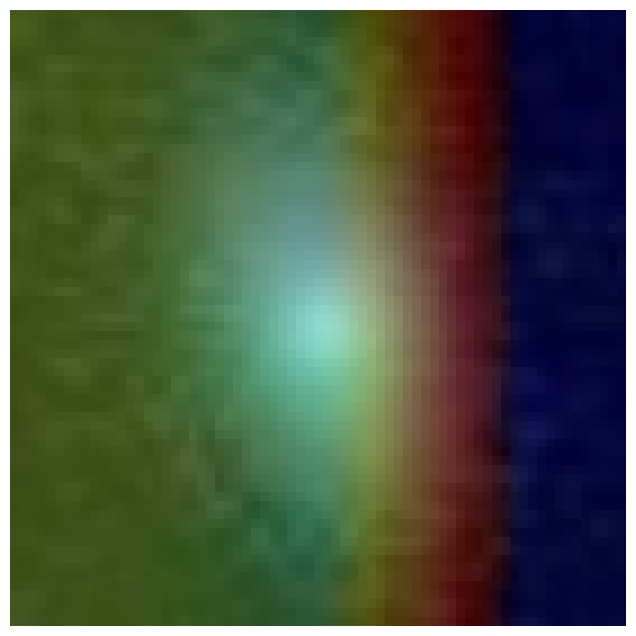

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('selfat/attention_overlay_image.jpg')

plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

It seems like the corners of the galaxy are used as a main classifier, which makes sense, as Galaxy10 galaxies are classified as spiral, barred spiral, etc depending on their shape and this is the easiest way to tell.